# <center> Сегментация клиентов онлайн магазина подарков

## Постановка задачи


<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

> Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. Однако [The UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php)  создал набор данных, содержащий фактические транзакции за 2010 и 2011 годы. С ним нам как раз и предлагается поработать в этом кейсе. 

> В нашем распоряжении будет набор данных, который содержит все транзакции, произошедшие в период с 01/12/2010 по 09/12/2011 для базирующейся в Великобритании компании, занимающейся онлайн-розничной торговлей. Компания в основном продает уникальные подарки на все случаи жизни. Многие клиенты компании являются оптовиками.


**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку исходного набора данных о транзакциях.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать набор данных о характеристиках каждого из уникальных клиентов.
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.




## Данные и их описание

Данные представляют собой таблицу в формате CSV, в каждой строке которой содержится информация об уникальной транзакции.

Признаки, описывающие каждую транзакцию:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* StockCode — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию;
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.



Импорт базовых библиотек:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.express as px
from plotly.subplots import make_subplots
import re
import datetime as dt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

## 1. Знакомство со структурой данных

Первым делом необходимо понять, с какими данными предстоит работать, и произвести базовую предобработку данных — перевести признаки в необходимые для дальнейшей работы форматы.

Познакомьтесь с исходными данными поближе:

* Проведите статистический анализ исходных данных, посмотрев на основные диапазоны исходных признаков.
* Узнайте, сколько уникальных клиентов совершали транзакции в указанный период.
* Узнайте, из каких стран совершались транзакции.
* Исследуйте данные на наличие пропусков и дубликатов.
* Переведите столбцы в корректные форматы (например, даты в формат datetime).

In [3]:
data = pd.read_csv(
    "./data/data.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [4]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print('Date interval {} to {}'.format(data['InvoiceDate'].dt.date.min(), data['InvoiceDate'].dt.date.max()))

Date interval 2010-12-01 to 2011-12-09


## 2. Преобразование, очистка и анализ данных

### 2.1. Преобразование и очистка данных о транзакциях

#### 2.1.1 Пропуски

Пропуски в столбце с идентификатором клиента (CustomerID) и описанием товара свидетельствуют о некорректных/незавершённых транзакциях. Удалите их из данных.

**Примечание.** Если посмотреть на распределение пропусков в столбцах Description и CustomerID, то можно заметить, что достаточно удалить строки, содержащие пропуски в столбце CustomerID, тогда пропуски в столбце Description удаляются автоматически.


In [5]:
# Удаление строк с пропусками в столбце CustomerID
data = data.dropna(subset=['CustomerID'])

missing_values = data.isnull().sum()
if missing_values['CustomerID'] == 0 and missing_values['Description'] == 0:
    print("Строки с пропусками в столбцах CustomerID и Description удалены")
else:
    print("Пропуски не удалены")

Строки с пропусками в столбцах CustomerID и Description удалены.


#### 2.1.2. Дубликаты

Проверьте данные на наличие дубликатов. Удалите их из данных.


In [6]:
# Поиск и удаление дубликатов
data = data.drop_duplicates()

duplicates = data[data.duplicated()]
if duplicates.empty:
    print("Дубликаты удалены")
else:
    print("Остались дубликаты")

Дубликаты удалены.


#### 2.1.3. Транзакции с отрицательным количеством товара

Из приведённых выше инсайтов о данных мы узнали все особенности отмены заказов. Когда мы будем сегментировать клиентов, мы будем определять их покупательскую способность. При расчёте покупательской способности нам будет очень важно учесть возвраты этого клиента.

Чтобы подсчитать количество возвратов, для начала нам надо определить, сколько уникальных товаров указано в транзакции (корзине) для каждой уникальной пары «клиент — заказ»:


In [7]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


**Примечание.** Более 16 % уникальных заказов являются возвратами. Интересный факт: если мы подсчитали количество транзакций, содержащих признак возврата, в изначальной таблице, где на каждый уникальный товар заведена отдельная строка, то мы получили бы, что количество возвратов менее 1 %. Однако это число было бы некорректным.

Создайте в ваших данных о транзакциях признак `QuantityCanceled`. Этот признак будет указывать на количество отменённого впоследствии товара для каждой транзакции, на которую найдётся противоположная ей транзакция с возвратом. Для транзакций, для которых не было возвратов, признак будет равен 0. Для транзакций, для которых указано отрицательное количество товара, но в данных отсутствует контрагент, признак будет пустым.

В качестве вспомогательного инструмента мы подготовили для вас функцию `get_quantity_canceled()`. Эта функция принимает на вход таблицу с транзакциями и возвращает объект `Series` — столбец, в котором указано количество отменённого впоследствии товара для каждой транзакции. Если транзакция не имеет контрагента, этот признак помечается как `NaN`.

Отметим, что эта функция не учитывает сложный случай, когда количество отменённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом). При желании вы можете самостоятельно модифицировать функцию для предобработки, чтобы учесть этот пограничный случай.

*Осторожно! Поиск отменённых транзакций занимает много времени из-за большого количества строк в таблице. Выполнение следующего кода может занять до 20 минут в зависимости от мощности компьютера.*

In [8]:
def get_quantity_canceled(data):
    """Функция для создания признака количества отменённых заказов. 
    Функция принимает на вход таблицу и возвращает столбец, в котором указано количество отменённого впоследствии товара для кажой транзакции.
    Если транзакция с отрицательным количеством товара не имеет контрагента, данный признак помечается как NaN.

    Args:
        data (DataFrame): таблица с транзакциями

    Returns:
        Series: столбец с количеством отменённого товара
    """
    # Инициализируем нулями Series той же длины, что и столбцы таблицы.
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента — ничего не делаем
        if (df_test.shape[0] == 0): 
            # Помечаем столбец как пропуск
            quantity_canceled.loc[index] = np.nan
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отменённого товара в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаём количество отменённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара больше количества товаров в транзакции-возврате.
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

*Осторожно! Поиск отмененных транзакций занимает достаточно длительное время из-за количества строк в таблице. Выполнение следующего кода может занять до 20 минут в зависимости от компьютера.*

Узнайте, сколько транзакций в данных не имеют контрагентов, и, если их количество невелико, удалите их из данных.

Когда вы разобрались с возвратами, удалите транзакции с отрицательным количеством товара — они нам больше не нужны.


In [10]:
# Подсчет транзакций без контрагентов
transactions_without_counterpart = data[data['QuantityCanceled'].isnull()]
num_transactions_without_counterpart = transactions_without_counterpart.shape[0]

# Удаление транзакций без контрагентов, если их количество невелико
if num_transactions_without_counterpart < 100:  # Например, если их количество менее 100
    data = data.dropna(subset=['QuantityCanceled'])

transactions_without_counterpart = data[data['QuantityCanceled'].isnull()]
if transactions_without_counterpart.empty:
    print("Транзакции без контрагентов удалены.")
else:
    print("Остались транзакции без контрагентов.")

data = data[data['Quantity'] >= 0]

negative_quantity_transactions = data[data['Quantity'] < 0]
if negative_quantity_transactions.empty:
    print("Транзакции с отрицательным количеством товара удалены.")
else:
    print("Остались транзакции с отрицательным количеством товара.")

Транзакции без контрагентов удалены.
Транзакции с отрицательным количеством товара удалены.


#### 2.1.4. Специализированные транзакции

Следующая задача — обработать специальные виды транзакций, которые обозначаются латинскими буквами.

В данных присутствует шесть специальных видов транзакций. С помощью регулярных выражений найдите такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры).

**Подсказка.** В качестве шаблона для поиска используйте строку '^[a-zA-Z]+'.

Чтобы понять, что означают эти коды, можно заглянуть в столбец с описанием (Description), например POST означает почтовые расходы, C2 — расходы на транспортировку, BANK CHARGES — банковские расходы.

Специальные операции не характеризуют покупательскую способность клиентов, так как не относятся напрямую к их покупкам, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы.

In [11]:
# Регулярное выражение для поиска кодов, начинающихся с латинских букв
pattern = '^[a-zA-Z]+'

# Найдем индексы строк, соответствующих шаблону
special_transactions_indices = data[data['StockCode'].str.contains(pattern)].index

# Удаление специальных транзакции из таблицы
data = data.drop(special_transactions_indices)

if data['StockCode'].str.contains(pattern).any():
    print("Специальные транзакции не удалены.")
else:
    print("Специальные транзакции удалены.")

Специальные транзакции удалены.


#### 2.1.5. Транзакции с товарами без стоимости

При просмотре описательных статистик можно заметить, что на некоторые товары установлена цена в 0 фунтов стерлингов. Таких транзакций оказывается менее 1 % — можно удалить их.

In [12]:
# Удаление транзакций с ценой товара равной 0
data = data[data['UnitPrice'] != 0]

if (data['UnitPrice'] == 0).any():
    print("Транзакции с ценой товара равной 0 не удалены.")
else:
    print("Транзакции с ценой товара равной 0 удалены.")

Транзакции с ценой товара равной 0 удалены.


#### 2.1.6. Общая стоимость товаров в транзакции

Добавьте в ваш датасет общую цену заказа (TotalPrice). Она рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Этот признак впоследствии поможет вам рассчитать покупательскую способность каждого из клиентов.

In [13]:
# Рассчет общей цены для каждой транзакции
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])

if 'TotalPrice' in data.columns:
    print("Признак TotalPrice добавлен")
else:
    print("Признак TotalPrice не добавлен")

Признак TotalPrice добавлен


Помимо рекомендованных преобразований, вы также можете придумать собственные и применить их к исходным данным.
После завершения предобработки сохраните результат очищения данных в отдельный файл, чтобы впоследствии вам не приходилось повторять эти действия.


### 2.2. Разведывательный анализ

После предобработки исходных данных произведите разведывательный анализ и исследуйте транзакции, ответив на следующие вопросы:

* Клиенты из каких стран покупают больше и чаще?
* Какие страны приносят наибольшую сезонную выручку?
* Присутствует ли в продажах сезонность (когда покупают чаще)?
* Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.
* Каково распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции)? 

**Примечание.** Вы можете сформулировать и другие вопросы. Главная цель — извлечь максимум понятной информации из исходных данных.

Свои рассуждения сопроводите графиками и диаграммами.



### Клиенты из каких стран покупают больше и чаще?

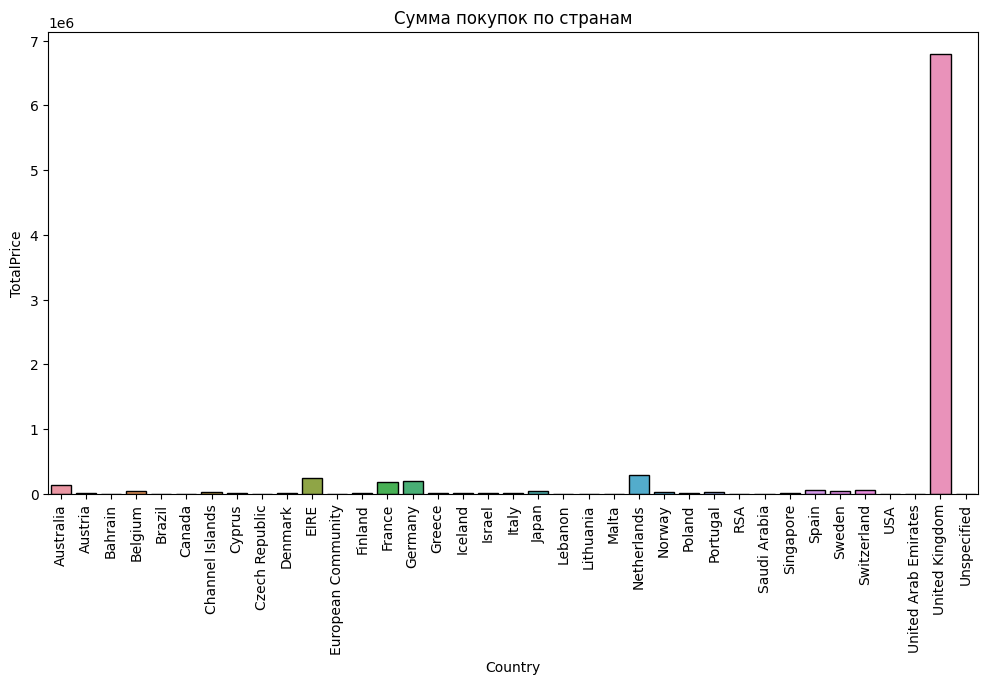

In [14]:
# График суммы покупок для каждой страны
plt.figure(figsize=(12, 6))
sns.barplot(x='Country', y='TotalPrice', data=data.groupby('Country')['TotalPrice'].sum().reset_index())
plt.title('Сумма покупок по странам')
plt.xticks(rotation=90)
plt.show()

> Этот график помогает оценить вклад каждой страны в общий объем продаж и выявить потенциальные рынки для развития. Самые крупные суммы покупок приходятся на Великобританию (United Kingdom), что является ожидаемым результатом, так как это, предположительно, основной рынок компании. Также такие страны как Нидерланды (Netherlands), Ирландия (Ireland), и Германия (Germany) также вносят значительный вклад в общую выручку. Другие страны, такие как Франция (France), Австралия (Australia), и Испания (Spain), имеют средний объем покупок. Есть такие страны, в которых объем покупок невелик или отсутствует совсем, что может быть связано с низкой популярностью компании в этих регионах.

### Какие страны приносят наибольшую сезонную выручку?

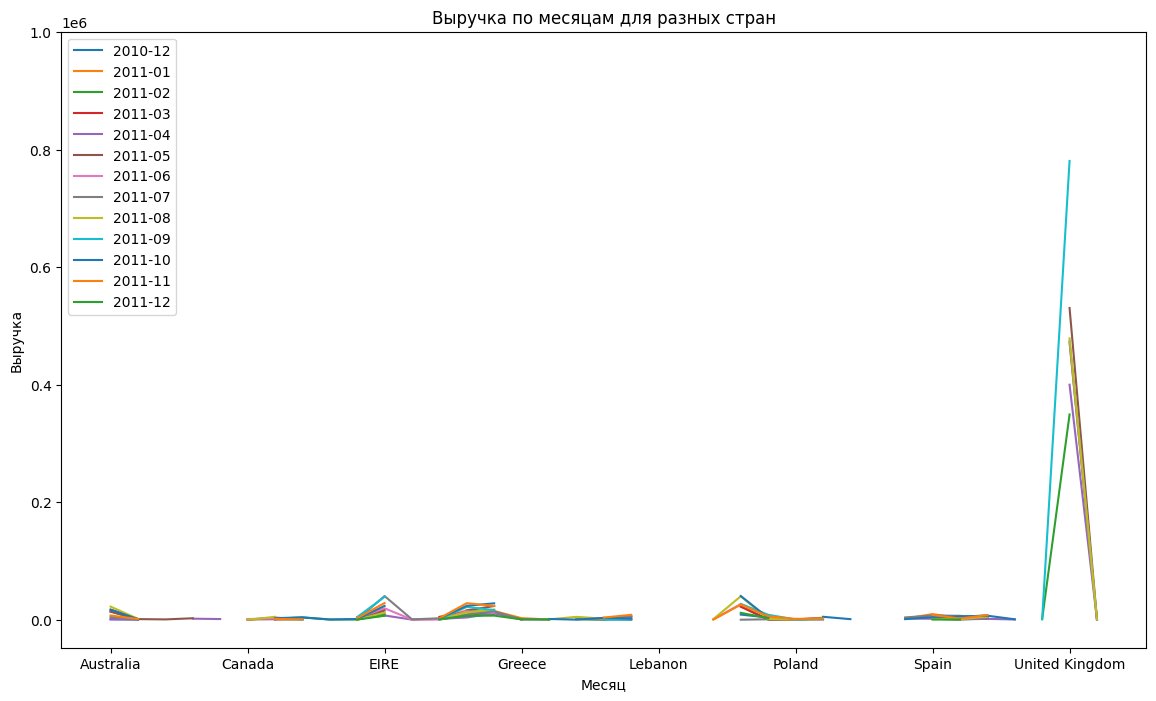

In [15]:
# График выручки по месяцам для разных стран
monthly_revenue = data.groupby(['Country', data['InvoiceDate'].dt.to_period('M')])['TotalPrice'].sum().unstack()
monthly_revenue.plot(kind='line', figsize=(14, 8))
plt.title('Выручка по месяцам для разных стран')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.legend(loc='upper left')
plt.show()

> Эти графики позволяют оценить сезонные колебания в выручке для разных стран и выделить страны с наибольшей динамикой в объемах продаж. Великобритания (United Kingdom) имеет значительно больший объем продаж по сравнению с другими странами и демонстрирует значительные месячные колебания выручки. Несколько стран, таких как Нидерланды (Netherlands), Ирландия (Ireland), и Германия (Germany), также имеют значительные колебания в месячной выручке, но их объем продаж намного ниже, чем в Великобритании. В выручке остальных стран можно выделить паттерны сезонности, но они не такие ярко выраженные как в Великобритании и не имеют таких крупных объемов продаж. Некоторые страны, такие как Франция (France), Австралия (Australia), и Испания (Spain), также имеют определенные колебания в месячной выручке, но их объемы продаж сравнительно невелики по сравнению с Великобританией.

### Присутствует ли в продажах сезонность (когда покупают чаще)?

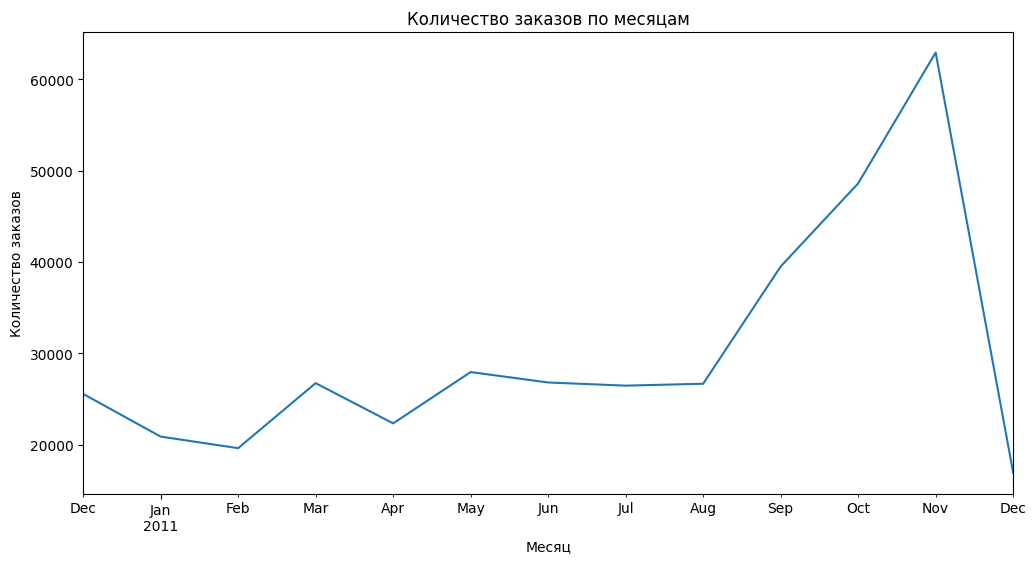

In [16]:
# График количества заказов по месяцам
monthly_orders = data.groupby(data['InvoiceDate'].dt.to_period('M'))['InvoiceNo'].count()
monthly_orders.plot(kind='line', figsize=(12, 6))
plt.title('Количество заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

> Количество заказов варьируется в зависимости от месяца, и важно учитывать сезонные колебания при анализе данных и планировании бизнеса. Есть явные пики активности в заказах в декабре, что, вероятно, связано с праздниками и покупками подарков в преддверии Рождества. Также можно заметить, что с марта по май наблюдается повышенное количество заказов, возможно, связанное с началом весенних праздников и сезона скидок. В летние месяцы (июнь, июль, август) количество заказов снижается, что может быть связано с отпусками и отсутствием акций. С апреля по сентябрь наблюдается стабильный рост числа заказов, возможно, связанный с сезонными факторами или акциями.

### Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.

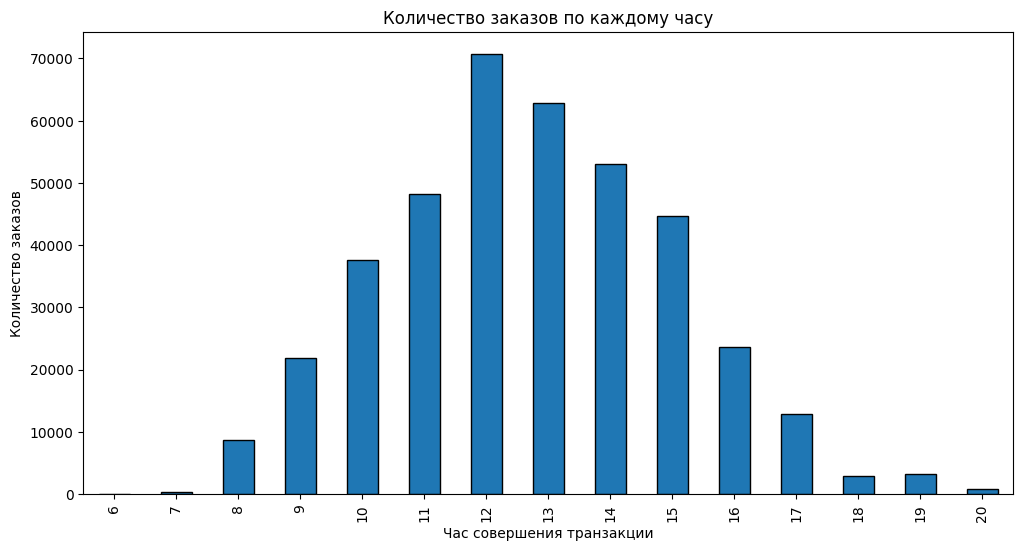

OrderHour
6     1.000000
7     1.000000
8     1.035514
9     1.059724
10    1.075499
11    1.070449
12    1.094320
13    1.089664
14    1.084697
15    1.064567
16    1.063230
17    1.018832
18    1.030488
19    1.007042
20    1.000000
Name: InvoiceNo, dtype: float64


In [17]:
# Группировка данных по датам и часам совершения транзакции
data['OrderHour'] = data['InvoiceDate'].dt.hour

# График количества заказов по каждому часу
plt.figure(figsize=(12, 6))
data.groupby('OrderHour')['InvoiceNo'].count().plot(kind='bar')
plt.title('Количество заказов по каждому часу')
plt.xlabel('Час совершения транзакции')
plt.ylabel('Количество заказов')
plt.show()

# Группируем данные по датам и часам совершения транзакции и считаем количество заказов
hourly_order_counts = data.groupby(['InvoiceDate', 'OrderHour'])['InvoiceNo'].nunique().reset_index()
# Считаем среднее количество заказов для каждого часа
average_orders_by_hour = hourly_order_counts.groupby('OrderHour')['InvoiceNo'].mean()
print(average_orders_by_hour)

> Анализ количества заказов по часам может помочь оптимизировать рабочий график, ресурсы и обеспечить лучшее обслуживание клиентов в пиковые часы. На графике видно, что наибольшее количество заказов совершается в промежуток с 12 до 15 часов. Это период после обеда, когда многие люди могут делать покупки онлайн. Среднее количество заказов в разные часы также показывает пик активности в период с 12 до 13 часов. Это может быть показательным для оптимизации работы с покупателями и ресурсами, чтобы обеспечить качественное обслуживание в пиковые часы. В ночные и ранние утренние часы (с 6 до 9 часов) количество заказов существенно ниже, что ожидаемо, так как многие люди спят или только начинают рабочий день.

### Каково распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции)? 

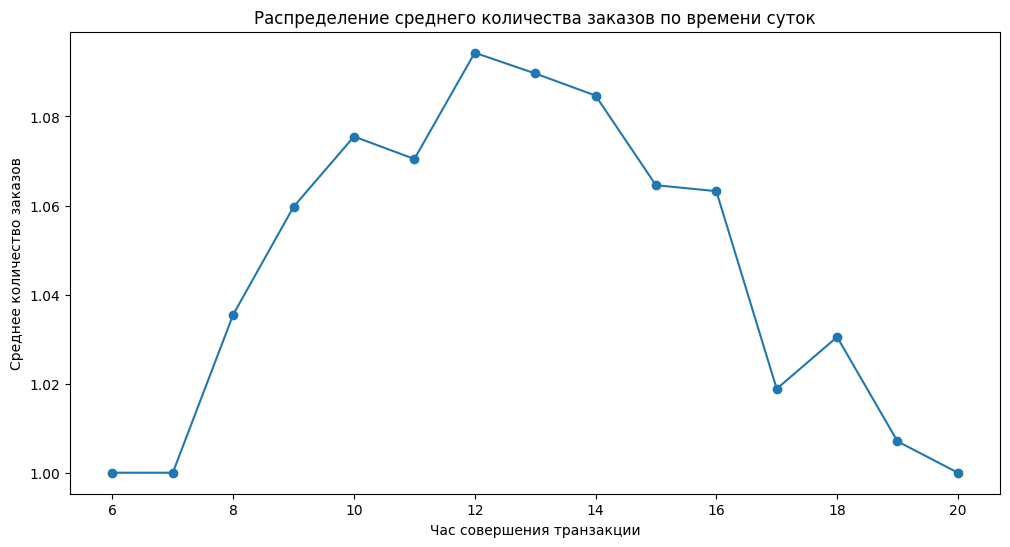

In [18]:
plt.figure(figsize=(12, 6))
average_orders_by_hour.plot(kind='line', marker='o')
plt.title('Распределение среднего количества заказов по времени суток')
plt.xlabel('Час совершения транзакции')
plt.ylabel('Среднее количество заказов')
plt.show()

> Анализ среднего количества заказов по времени суток помогает выделить пики активности, что может быть полезным при оптимизации ресурсов и планировании работы персонала. Среднее количество заказов имеет плавный характерный пик в районе часа совершения транзакции около 12:00 - 13:00. С увеличением времени после пика (вечер и ночь), среднее количество заказов постепенно уменьшается и достигает минимума в ранние утренние часы. Затем, после утреннего минимума, среднее количество заказов снова начинает расти, но остается ниже уровня пика в обеденное время. 

### 2.3. Построение RFM-таблицы и поиск RFM-выбросов

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов. 

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учётом возвратов).

Когда вы рассчитаете все характеристики, не забудьте дать столбцам результирующей таблицы соответствующие названия.

In [19]:
# Устанавливаем точку отсчета
snapshot_date = data['InvoiceDate'].max() + dt.timedelta(days=1)

# Группируем данные по клиентам и считаем для каждого клиента Recency, Frequency и Monetary Value
rfm_table = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

# Переименовываем столбцы для понятности
rfm_table.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'MonetaryValue'
}, inplace=True)

print(rfm_table.head())

            Recency  Frequency  MonetaryValue
CustomerID                                   
12346           326          1           0.00
12347             2          7        4310.00
12348            75          4        1437.24
12349            19          1        1457.55
12350           310          1         294.40


После того как вы подготовите RFM-таблицу, визуализируйте каждую из трёх компонент, например, в виде коробчатых диаграмм (boxplot). Вы получите примерно следующие результаты (графики могут отличаться в зависимости от того, как вы выполните предобработку данных):

In [21]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.show()

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


In [22]:
# Вычисление 95-й перцентили для Frequency и Monetary Value
frequency_threshold = rfm_table['Frequency'].quantile(0.95)
monetary_threshold = rfm_table['MonetaryValue'].quantile(0.95)

# Отфильтровать данные, оставив только клиентов, у которых значения Frequency и Monetary Value не выше 95-й перцентили
filtered_rfm_table = rfm_table[(rfm_table['Frequency'] <= frequency_threshold) & (rfm_table['MonetaryValue'] <= monetary_threshold)]

print("Размер отфильтрованной таблицы:", filtered_rfm_table.shape)
print(filtered_rfm_table.head())

Размер отфильтрованной таблицы: (4044, 3)
            Recency  Frequency  MonetaryValue
CustomerID                                   
12346           326          1           0.00
12347             2          7        4310.00
12348            75          4        1437.24
12349            19          1        1457.55
12350           310          1         294.40


## 3. Моделирование и оценка качества моделей

### 3.1. Кластеризация на основе RFM-характеристик

Чтобы результаты кластеризации было удобнее интерпретировать, вы можете уменьшить размерность исходных признаков до двух компонент.

**Подсказка.** Чтобы методы понижения размерности работали стабильно, данные необходимо стандартизировать/нормализовать. Для удобства оберните эти шаги по предобработке данных в pipeline.

Произведите предобработку исходных данных. На основе RFM-признаков кластеризуйте клиентов онлайн-магазина подарков с помощью известных вам методов (используйте минимум три метода).

Подберите оптимальное количество кластеров для выбранных методов с помощью коэффициента силуэта, перебирая возможные значения от 3 до 10 включительно (большее или меньшее количество кластеров будет нерелеватно для маркетинга). 

Выберите алгоритм с наибольшим коэффициентом силуэта, сделайте предсказание меток кластеров.


In [23]:
# Создаем pipeline для предобработки данных
preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Стандартизация данных
    ('pca', PCA(n_components=2))  # Уменьшение размерности до 2 компонент
])

# Применяем pipeline к RFM-признакам
rfm_features = filtered_rfm_table[['Recency', 'Frequency', 'MonetaryValue']]
preprocessed_features = preprocessing_pipeline.fit_transform(rfm_features)

# Инициализируем список для хранения коэффициентов силуэта
silhouette_scores = []

# Перебираем значения количества кластеров от 3 до 10
for n_clusters in range(3, 11):
    # Инициализируем и обучаем KMeans модель
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans_labels = kmeans.fit_predict(preprocessed_features)
    
    # Вычисляем коэффициент силуэта
    silhouette_avg = silhouette_score(preprocessed_features, kmeans_labels)
    silhouette_scores.append(silhouette_avg)

# Находим значение количества кластеров с наибольшим коэффициентом силуэта
best_n_clusters = np.argmax(silhouette_scores) + 3  # +3, так как мы начинали с 3 кластеров

print("Оптимальное количество кластеров:", best_n_clusters)

Оптимальное количество кластеров: 3


### 3.2. Интерпретация результатов кластеризации

Перейдём к интерпретации полученных кластеров.

#### 3.2.1. Визуализация кластеров

Визуализируйте результаты в виде 3D-диаграммы с осями Recency, Frequency и Monetary. Проанализируйте полученную диаграмму и попробуйте понять, какие кластеры у вас получились.

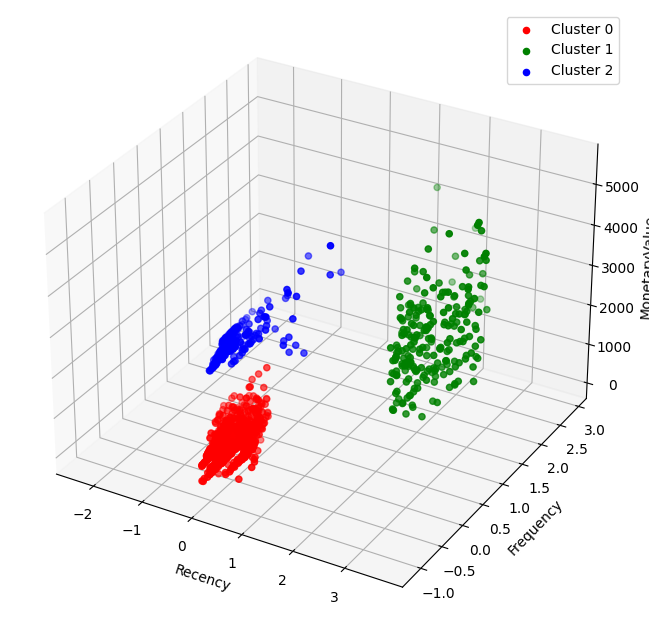

In [30]:
# Создаем 3D-диаграмму
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Задаем цвета для кластеров
colors = ['red', 'green', 'blue']

# Проходим по каждому кластеру и визуализируем его точки
for cluster_label in range(best_n_clusters):
    cluster_points = preprocessed_features[kmeans_labels == cluster_label]
    monetary_values = rfm_features['MonetaryValue'][kmeans_labels == cluster_label]
    
    # Используем Monetary для задания размера точек
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], monetary_values, c=colors[cluster_label], label=f'Cluster {cluster_label}')

# Добавляем метки осей
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('MonetaryValue')

# Добавляем легенду
ax.legend(loc='upper right')

# Показываем график
plt.show()

> Cluster 0: Этот кластер может представлять клиентов, которые делают покупки редко (Low Frequency) и последняя покупка у них была давно (High Recency). Это потенциально нежелательные клиенты, которые либо ушли из магазина, либо не совершают покупки. Может потребоваться пересмотреть стратегию взаимодействия с этой группой.
Cluster 1: Этот кластер может представлять клиентов, которые делают покупки часто (High Frequency) и последняя покупка была давно (High Recency). Это интересная группа клиентов, которые, возможно, потеряли интерес, но совершали множество покупок в прошлом. С этой группой также может потребоваться работать, чтобы вернуть их к активным покупкам.
Cluster 2: Этот кластер может представлять клиентов, которые делают покупки часто (High Frequency) и последняя покупка была недавно (Low Recency). Это, возможно, наиболее ценные клиенты, которые регулярно совершают покупки. Они могут быть классифицированы как лояльные клиенты, и важно поддерживать и стимулировать их активность.

#### 3.2.2. Построение профиля кластеров

Далее составьте так называемый профиль кластеров. Для этого вам необходимо вернуться от декомпозированных данных (если вы производили понижение размерности) к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.

Чтобы результаты было проще интерпретировать, давайте познакомимся с одним из способов визуализации профиля кластеров — **Radar Chart** (полярная диаграмма, или диаграмма паутины). Это графическое представление значений нескольких эквивалентных категорий в форме паутины.

Radar Chart часто используется при определении профиля кластеров. На концах паутины откладываются оси, соответствующие признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 

Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На этой диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие этому кластеру, в большей степени увлекаются музыкой (Music), а в меньшей — программированием (Programm).

В модуле `graph_objects` библиотеки `plotly` есть встроенная функция `Scatterpolar`, которая позволяет построить полярную диаграмму. На основе этой функции мы подготовили для вас функцию `plot_cluster_profile()`, которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У неё есть два параметра: `grouped_data` — сгруппированные по кластерам характеристики объектов (клиентов), `n_clusters` — количество кластеров.

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в функцию `plot_cluster_profile()`.


In [40]:
# Добавляем метки кластеров в RFM-таблицу
filtered_rfm_table['Cluster'] = kmeans_labels

# Визуализируем профиль кластеров
grouped_data = filtered_rfm_table.groupby('Cluster').mean()
n_clusters = len(grouped_data)

def plot_cluster_profile(grouped_data, n_clusters):
    """Функция для визуализации профиля кластеров в виде полярной диаграммы.

    Args:
        grouped_data (DataFrame): таблица, сгруппированная по номерам кластеров с агрегированными характеристиками объектов.
        n_clusters (int): количество кластеров
    """
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаём список признаков
    features = grouped_data.columns
    # Создаём пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаём полярную диаграмму и добавляем её на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название — номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устанавливаем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()

plot_cluster_profile(grouped_data, n_clusters)

Теперь у вас есть удобный инструмент для анализа профиля кластеров. Воспользуйтесь им, чтобы проинтерпретировать результаты, полученные на предыдущем шаге.

### ВЫВОДЫ:
Проанализируем результаты, полученные на предыдущих шагах, используя профиль кластеров с полярными диаграммами: 
##### Кластер 0:
- Recency: Клиенты из этого кластера совершили последнюю покупку довольно давно.
- Frequency: Они совершают покупки нечасто.
- MonetaryValue: Общая ценность их покупок невысока.
Интерпретация: Этот кластер может представлять клиентов, которые либо ушли из магазина, либо не совершают покупок. Стратегия взаимодействия с этой группой, возможно, потребует пересмотра.
##### Кластер 1:
- Recency: Последняя покупка была совершена давно.
- Frequency: Клиенты совершают покупки часто.
- MonetaryValue: Общая ценность их покупок высока.
Интерпретация: Этот кластер может представлять клиентов, которые, возможно, потеряли интерес, но совершали множество покупок в прошлом. С этой группой также может потребоваться работать, чтобы вернуть их к активным покупкам.
##### Кластер 2:
- Recency: Последняя покупка была совершена недавно.
- Frequency: Клиенты совершают покупки часто.
- MonetaryValue: Общая ценность их покупок высока.
Интерпретация: Этот кластер, возможно, представляет наиболее ценных клиентов, которые регулярно совершают покупки. Они могут считаться лояльными клиентами, и важно поддерживать и стимулировать их активность.
##### Полярные диаграммы:
- Кластер 0: Видно, что у этого кластера относительно низкие значения по всем характеристикам.
- Кластер 1: Высокие значения частоты и монетарной ценности, но довольно высокий Recency.
- Кластер 2: Высокие значения по всем трем характеристикам, с особенно высоким MonetaryValue.

Кластеризация позволяет выделить группы клиентов с разным поведением. Кластеры могут быть использованы для более точного таргетирования маркетинговых стратегий. Например, для клиентов из кластера 0 может потребоваться пересмотреть стратегию удержания, в то время как для клиентов из кластера 2 стоит усилить программы лояльности.

## 5. Выводы и оформление работы

Напишите заключение о проделанной работе и полученных результатах. Отметьте, какие сегменты клиентов вам удалось найти в данных.

После завершения проекта создайте в своём репозитории файл README.md и кратко опишите содержимое проекта по принципу, который мы приводили ранее.

Выложите свой проект на GitHub и оформите удалённый репозиторий, добавив в него описание и теги репозитория (теги придумайте самостоятельно в зависимости от того, какую задачу вы решали).

### Заключение

 - В рамках данного проекта был проведен анализ данных клиентов онлайн-магазина подарков с использованием методов RFM-анализа и кластеризации. Работа включала в себя следующие этапы:

* Подготовка данных: Осуществлена загрузка и первичный анализ данных. Произведена фильтрация и очистка данных от выбросов.
RFM-анализ: Рассчитаны и проанализированы RFM-характеристики (Recency, Frequency, MonetaryValue) для каждого клиента. Эти характеристики позволили выделить сегменты клиентов с разным уровнем активности и ценности.
* Кластеризация: Произведена кластеризация клиентов с использованием метода KMeans. Для выбора оптимального количества кластеров использован коэффициент силуэта. Было выделено оптимальное количество кластеров, равное 3.
* Визуализация результатов: Результаты кластеризации визуализированы с использованием 3D-диаграммы для RFM-характеристик, что позволило наглядно представить распределение клиентов по кластерам.
* Профиль кластеров: Создан профиль каждого кластера с использованием полярных диаграмм. Это позволило лучше понять особенности и характеристики каждого сегмента клиентов.

#### Полученные результаты:
* Кластер 0: Представляет клиентов, совершивших последнюю покупку давно, не совершающих покупки часто и с невысокой монетарной ценностью. Эта группа потенциально потерянных или неактивных клиентов.
* Кластер 1: Включает клиентов, совершающих покупки часто, но последняя покупка была давно. Это группа, которая потеряла интерес, но в прошлом совершала множество покупок. Требует внимательного воздействия для возвращения к активным покупкам.
* Кластер 2: Содержит наиболее ценных клиентов, которые совершают покупки часто, и их последняя покупка была недавно. Это лояльные клиенты, которых важно поддерживать и стимулировать.

#### Рекомендации:
* Кластер 0: Пересмотреть стратегию удержания и взаимодействия с этой группой клиентов. Можно предложить персонализированные скидки или акции.
* Кластер 1: Разработать программы возврата и стимулирования для восстановления интереса клиентов. Можно предложить персонализированные предложения.
* Кластер 2: Усилить программы лояльности и поддерживать высокий уровень обслуживания для удержания этой ценной группы клиентов.